In [6]:
!pip install seaborn

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import skew
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class StockDataDownloader:
    def __init__(self, tickers, start_date, end_date, interval):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval

    def download(self):
        return yf.download(self.tickers, start=self.start_date, end=self.end_date, interval=self.interval)['Close'] #Adj Close is default now

In [25]:
class PairsTradingBacktest:
    """
    Backtester for a z-score based pairs trading strategy using static OLS hedge ratio 
    and rolling statistics for the z-score calculation.
    """
    def __init__(self, stock1, stock2, initial_capital=10000, entry_z=2.0, exit_z=1.6,
                 trading_cost=0.001, min_holding=10, max_holding=63):
        
        # 1. Align and Clean Data
        combined = pd.concat([stock1, stock2], axis=1).dropna()
        self.stock1 = combined.iloc[:, 0]
        self.stock2 = combined.iloc[:, 1]

        self.ticker1 = self.stock1.name if self.stock1.name else 'Stock1'
        self.ticker2 = self.stock2.name if self.stock2.name else 'Stock2'

        # Strategy Parameters
        self.initial_capital = initial_capital
        self.entry_z = entry_z
        self.exit_z = exit_z
        self.trading_cost = trading_cost
        self.min_holding = min_holding
        self.max_holding = max_holding
        
        # Caching for efficiency
        self.hedge_ratio = None
        self._spread = None
        self._zscore = None

    def calculate_spread_zscore(self, window=30):
        """
        Calculates the static hedge ratio, spread, and rolling Z-score.
        Caches the results to prevent recalculation.
        """
        if self.hedge_ratio is None or self._spread is None or self._zscore is None:
            # 1. Calculate Static Hedge Ratio using OLS
            model = sm.OLS(self.stock1, sm.add_constant(self.stock2)).fit()
            self.hedge_ratio = model.params.iloc[1]

            # 2. Calculate Spread: S1 - HR * S2
            self._spread = self.stock1 - self.hedge_ratio * self.stock2

            # 3. Calculate Rolling Statistics
            rolling_mean = self._spread.rolling(window=window).mean()
            rolling_std = self._spread.rolling(window=window).std()

            # 4. Calculate Z-Score
            self._zscore = (self._spread - rolling_mean) / rolling_std
            self._zscore = self._zscore.dropna() # Trim due to rolling window

        return self._spread, self._zscore, self.hedge_ratio

    def max_drawdown(self, returns):
        """Calculates Max Drawdown from daily returns."""
        if len(returns) == 0:
            return pd.Series([0])
        # Returns can be a NumPy array or Pandas Series
        cumulative = np.cumprod(1 + returns)
        peak = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - peak) / peak
        return pd.Series(drawdown, index=returns.index) if isinstance(returns, pd.Series) else pd.Series(drawdown)

    def backtest(self):
        spread, zscore, hedge_ratio = self.calculate_spread_zscore()

        position = 0
        cash = self.initial_capital
        returns_list = [] # Renamed to avoid collision with final returns object
        entry_idx = None
        stock1_shares = 0
        stock2_shares = 0
        prev_value = cash
        
        # We iterate over the zscore index since it is the shortest
        for i in range(len(zscore)):
            current_idx = zscore.index[i]
            s1_price = self.stock1.loc[current_idx]
            s2_price = self.stock2.loc[current_idx]
            current_z = zscore.iloc[i]

            # --- ENTRY LOGIC ---
            if position == 0:
                unit_value = s1_price + abs(hedge_ratio) * s2_price
                temp_stock1_shares = cash / unit_value
                
                # 1. UPPER BOUND ENTRY (SHORT SPREAD: Short S1, Long S2)
                if current_z > self.entry_z:
                    stock1_shares = -temp_stock1_shares 
                    stock2_shares = abs(hedge_ratio) * temp_stock1_shares # Long S2
                    cash += abs(stock1_shares) * s1_price * (1 - self.trading_cost) 
                    cash -= abs(stock2_shares) * s2_price * (1 + self.trading_cost)
                    position = -1
                    entry_idx = i

                # 2. LOWER BOUND ENTRY (LONG SPREAD: Long S1, Short S2)
                elif current_z < -self.entry_z:
                    stock1_shares = temp_stock1_shares
                    stock2_shares = -abs(hedge_ratio) * temp_stock1_shares # Short S2
                    cash -= abs(stock1_shares) * s1_price * (1 + self.trading_cost)
                    cash += abs(stock2_shares) * s2_price * (1 - self.trading_cost)
                    position = 1
                    entry_idx = i

            # --- EXIT LOGIC ---
            elif position != 0:
                holding_period = i - entry_idx
                
                exit_signal_long = position == 1 and current_z > -self.exit_z
                exit_signal_short = position == -1 and current_z < self.exit_z
                time_out = holding_period >= self.max_holding

                if (holding_period >= self.min_holding and (exit_signal_long or exit_signal_short)) or time_out:
                    
                    if position == 1: # Close Long Spread
                        cash += abs(stock1_shares) * s1_price * (1 - self.trading_cost) 
                        cash -= abs(stock2_shares) * s2_price * (1 + self.trading_cost) 
                    elif position == -1: # Close Short Spread
                        cash -= abs(stock1_shares) * s1_price * (1 + self.trading_cost) 
                        cash += abs(stock2_shares) * s2_price * (1 - self.trading_cost) 

                    position = 0
                    entry_idx = None
                    stock1_shares = 0
                    stock2_shares = 0

            # --- ACCOUNT VALUE CALCULATION ---
            value = cash + stock1_shares * s1_price + stock2_shares * s2_price

            if i > 0:
                # Store daily return
                returns_list.append((value - prev_value) / prev_value)
            prev_value = value

        # --- FINAL CLOSEOUT ---
        if position != 0:
            s1_price_final = self.stock1.iloc[-1]
            s2_price_final = self.stock2.iloc[-1]
            
            if position == 1: # Long Spread: Sell S1, Cover S2
                cash += abs(stock1_shares) * s1_price_final * (1 - self.trading_cost)
                cash -= abs(stock2_shares) * s2_price_final * (1 + self.trading_cost)
            elif position == -1: # Short Spread: Cover S1, Sell S2
                cash -= abs(stock1_shares) * s1_price_final * (1 + self.trading_cost)
                cash += abs(stock2_shares) * s2_price_final * (1 - self.trading_cost)
                
            value_final = cash
            returns_list.append((value_final - prev_value) / prev_value)

        # using the correct index (zscore starts the day before the first return)
        if len(returns_list) > 0:
            returns_index = zscore.index[len(zscore) - len(returns_list):]
            returns = pd.Series(returns_list, index=returns_index)
        else:
            returns = pd.Series([], dtype=float)


        # Performance Metrics
        total_return = (cash - self.initial_capital) / self.initial_capital
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if returns.std() != 0 else 0
        skewness = skew(returns) if len(returns) > 2 else 0
        max_dd = self.max_drawdown(returns).min() if len(returns) > 0 else 0

        results = {
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'skewness': skewness,
            'max_drawdown': max_dd,
            'returns': returns
        }
        return results

    def plot_all(self, results):
        spread, zscore, _ = self.calculate_spread_zscore()
        
        returns = results['returns'] # This is now a Pandas Series
        
        if len(returns) == 0:
            print("No trades occurred to plot returns/drawdown.")
            return

        cumulative_returns = (1 + returns).cumprod() - 1
        drawdown = self.max_drawdown(returns)

        fig, axs = plt.subplots(2, 2, figsize=(16, 10))

        # --- Top Left: Stock Prices --- (Correct)
        ax1 = axs[0, 0]
        ax1.plot(self.stock1.index, self.stock1, label=f'{self.ticker1} Price')
        ax1.plot(self.stock2.index, self.stock2, label=f'{self.ticker2} Price')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{self.ticker1} - {self.ticker2} Paired Stock Prices')
        ax1.legend()
        ax1.grid(True)
        
        # --- Top Right: Spread and Z-Score --- (Correct)
        ax2 = axs[0, 1]
        ax2.plot(spread.index, spread, label='Spread', color='blue')
        ax2.set_ylabel('Spread', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.grid(True)
        
        ax2_twin = ax2.twinx()
        ax2_twin.plot(zscore.index, zscore, label='Z-Score', color='orange')
        ax2_twin.axhline(self.entry_z, color='red', linestyle='--', label=f'Entry ({self.entry_z})')
        ax2_twin.axhline(-self.entry_z, color='red', linestyle='--')
        ax2_twin.axhline(self.exit_z, color='green', linestyle=':', label=f'Exit ({self.exit_z})')
        ax2_twin.axhline(-self.exit_z, color='green', linestyle=':')
        ax2_twin.axhline(0, color='gray', linestyle='-')
        ax2_twin.set_ylabel('Z-Score', color='orange')
        ax2_twin.tick_params(axis='y', labelcolor='orange')
        
        lines_1, labels_1 = ax2.get_legend_handles_labels()
        lines_2, labels_2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
        ax2.set_title(f'Spread and Z-Score vs. Strategy Thresholds')

        # --- Bottom Left: Cumulative Returns --- 
        ax3 = axs[1, 0]
        # FIX: returns.index is now valid
        ax3.plot(returns.index, cumulative_returns, label='Cumulative Returns', color='purple') 
        ax3.set_ylabel('Cumulative Return')
        ax3.set_title('Strategy Cumulative Returns')
        ax3.grid(True)
        ax3.legend()

        # --- Bottom Right: Drawdown ---
        ax4 = axs[1, 1]
        # FIX: returns.index is now valid
        ax4.plot(returns.index, drawdown, label='Drawdown', color='red') 
        ax4.set_ylabel('Drawdown')
        ax4.set_xlabel('Date Index')
        ax4.set_title('Strategy Drawdown')
        ax4.grid(True)
        ax4.legend()

        plt.tight_layout()
        plt.show()


class ThresholdOptimizer:
    """
    Optimizes the entry and exit Z-score thresholds for a PairsTradingBacktest 
    instance based on Sharpe Ratio maximization.
    """
    def __init__(self, backtester, entry_range=np.linspace(1.5, 4.0, 26), exit_range=np.linspace(0.0, 3.0, 31)):
        # CRITICAL FIX: The backtester instance passed here should be pre-calculated (efficient)
        self.backtester = backtester
        self.entry_range = entry_range
        self.exit_range = exit_range
        self.best_entry = None
        self.best_exit = None
        self.best_sharpe = -np.inf
        self.results_map = {}

    def optimize(self):
        # Pre-calculate the computationally expensive spread and zscore once
        self.backtester.calculate_spread_zscore()
        
        for entry_thresh in self.entry_range:
            for exit_thresh in self.exit_range:
                # Exit threshold must be strictly less than entry threshold
                if exit_thresh >= entry_thresh:
                    self.results_map[(entry_thresh, exit_thresh)] = -np.inf # Assign low Sharpe for invalid
                    continue
                
                # Update parameters on the existing backtester instance
                self.backtester.entry_z = entry_thresh
                self.backtester.exit_z = exit_thresh
                
                # Run backtest - now only the loop logic changes, the spread/zscore is cached.
                results = self.backtester.backtest()
                sharpe = results['sharpe_ratio']
                
                self.results_map[(entry_thresh, exit_thresh)] = sharpe
                
                if sharpe > self.best_sharpe:
                    self.best_sharpe = sharpe
                    self.best_entry = entry_thresh
                    self.best_exit = exit_thresh

        return self.best_entry, self.best_exit, self.best_sharpe

    def plot_heatmap(self):
        data = []
        for (e, x), sharpe in self.results_map.items():
            data.append({'Entry': e, 'Exit': x, 'Sharpe': sharpe})
        df = pd.DataFrame(data)
        
        # Pivot table and plotting remains correct
        pivot_table = df.pivot(index='Exit', columns='Entry', values='Sharpe')
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')
        plt.title('Sharpe Ratio Heatmap by Entry/Exit Thresholds')
        plt.xlabel('Entry Threshold')
        plt.ylabel('Exit Threshold')
        plt.gca().invert_yaxis()
        plt.show()

[*********************100%***********************]  10 of 10 completed


Pair XOM-CVX: Optimal entry: 1.9, exit: 0.0, Sharpe: 0.480


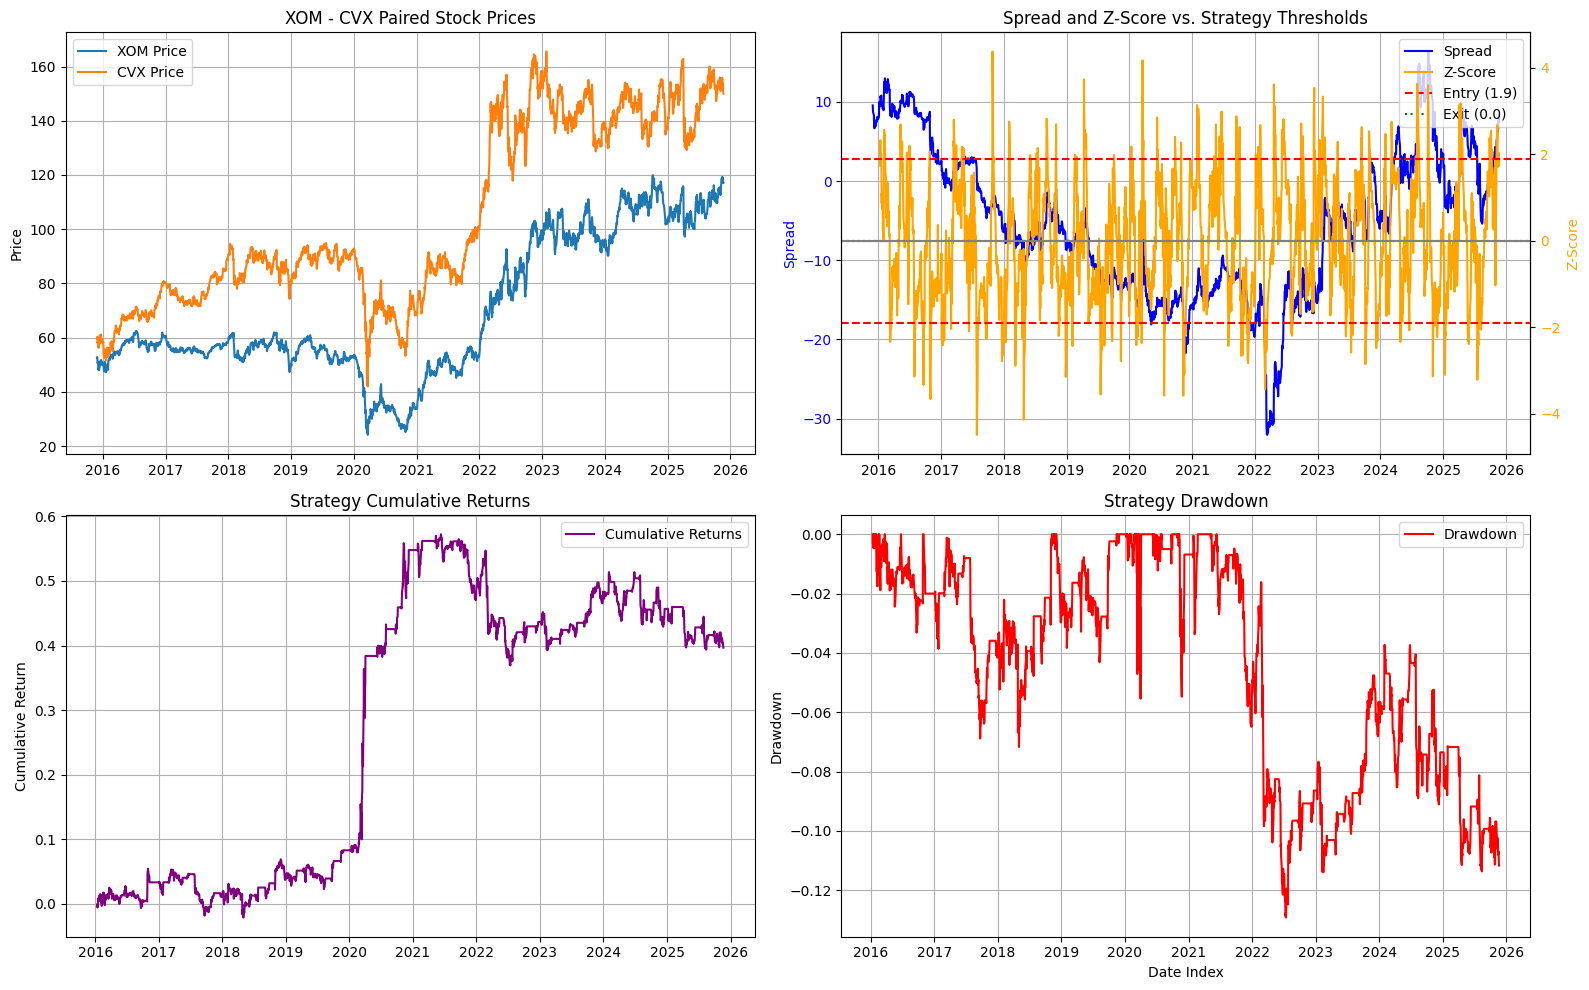

Pair KO-PEP: Optimal entry: 3.7, exit: 0.5, Sharpe: 0.226


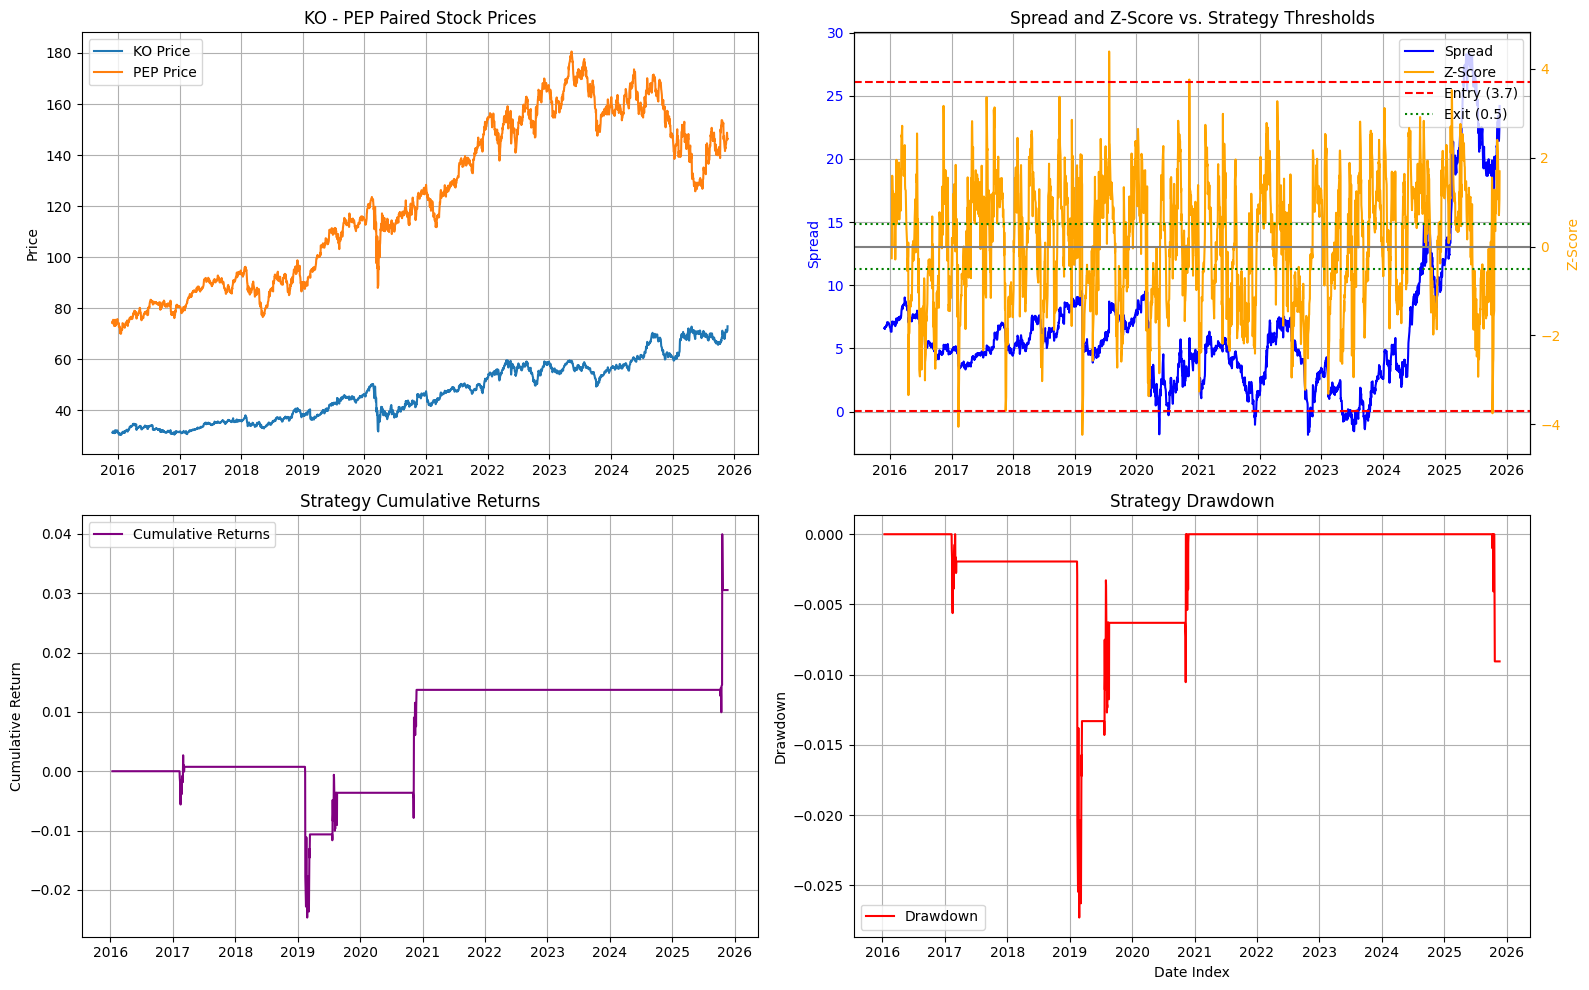

Pair JPM-BAC: Optimal entry: 2.8, exit: 0.30000000000000004, Sharpe: 0.533


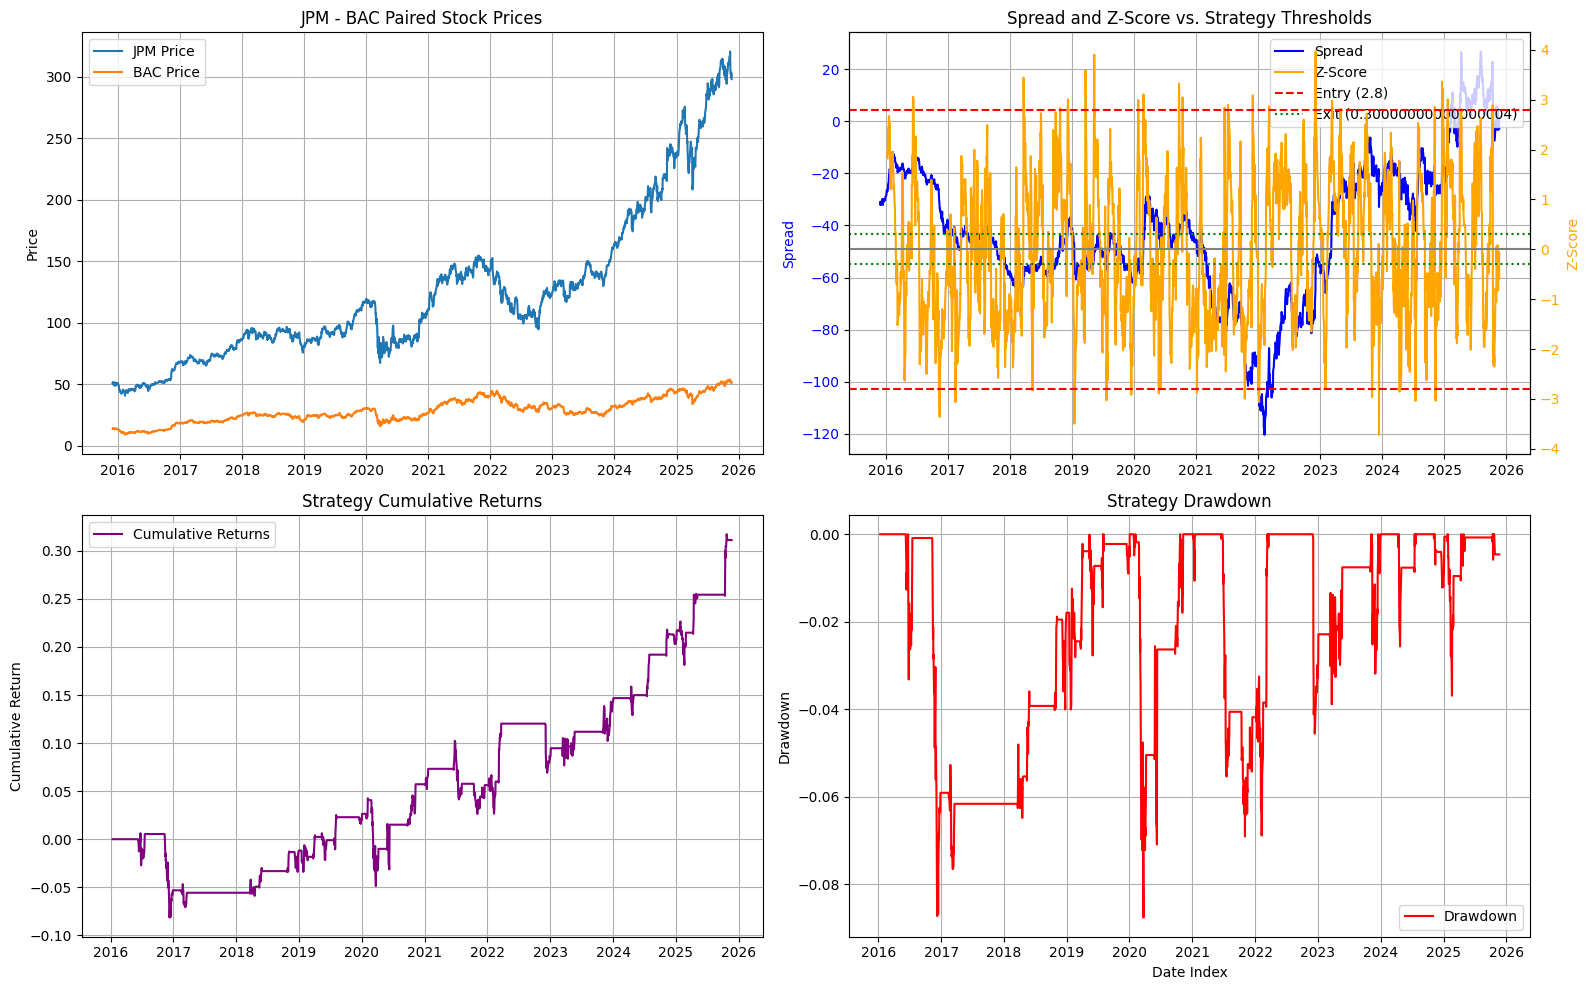

Pair BA-LMT: Optimal entry: 3.7, exit: 1.3, Sharpe: 0.405


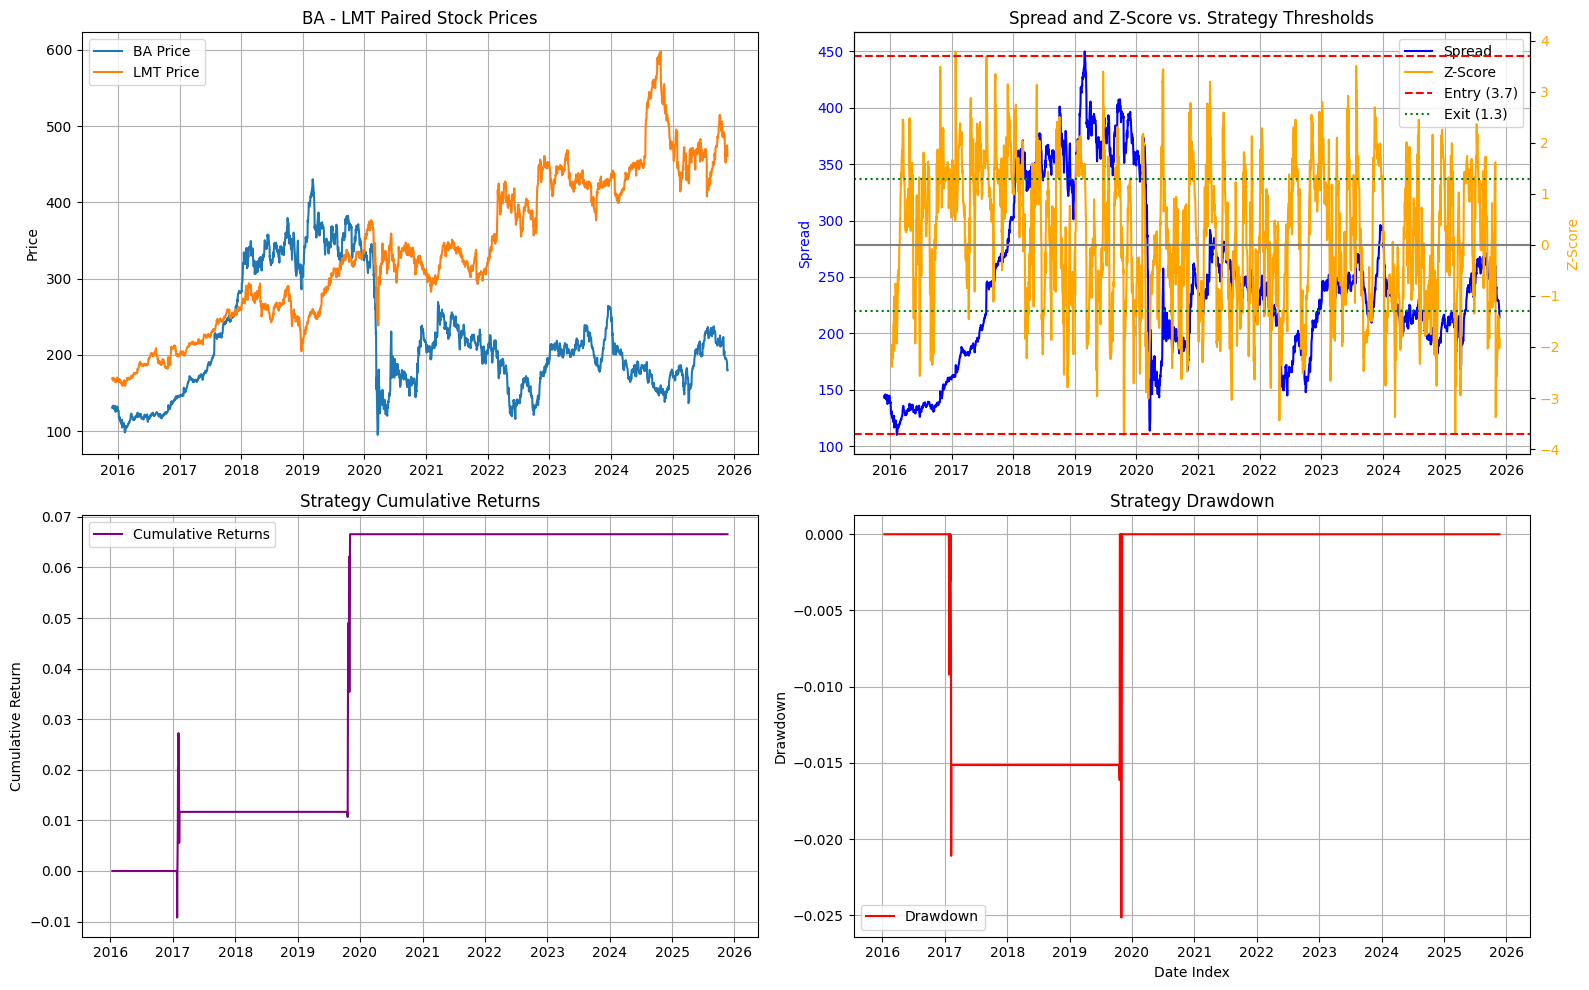

Pair MCD-YUM: Optimal entry: 1.9, exit: 0.30000000000000004, Sharpe: 0.336


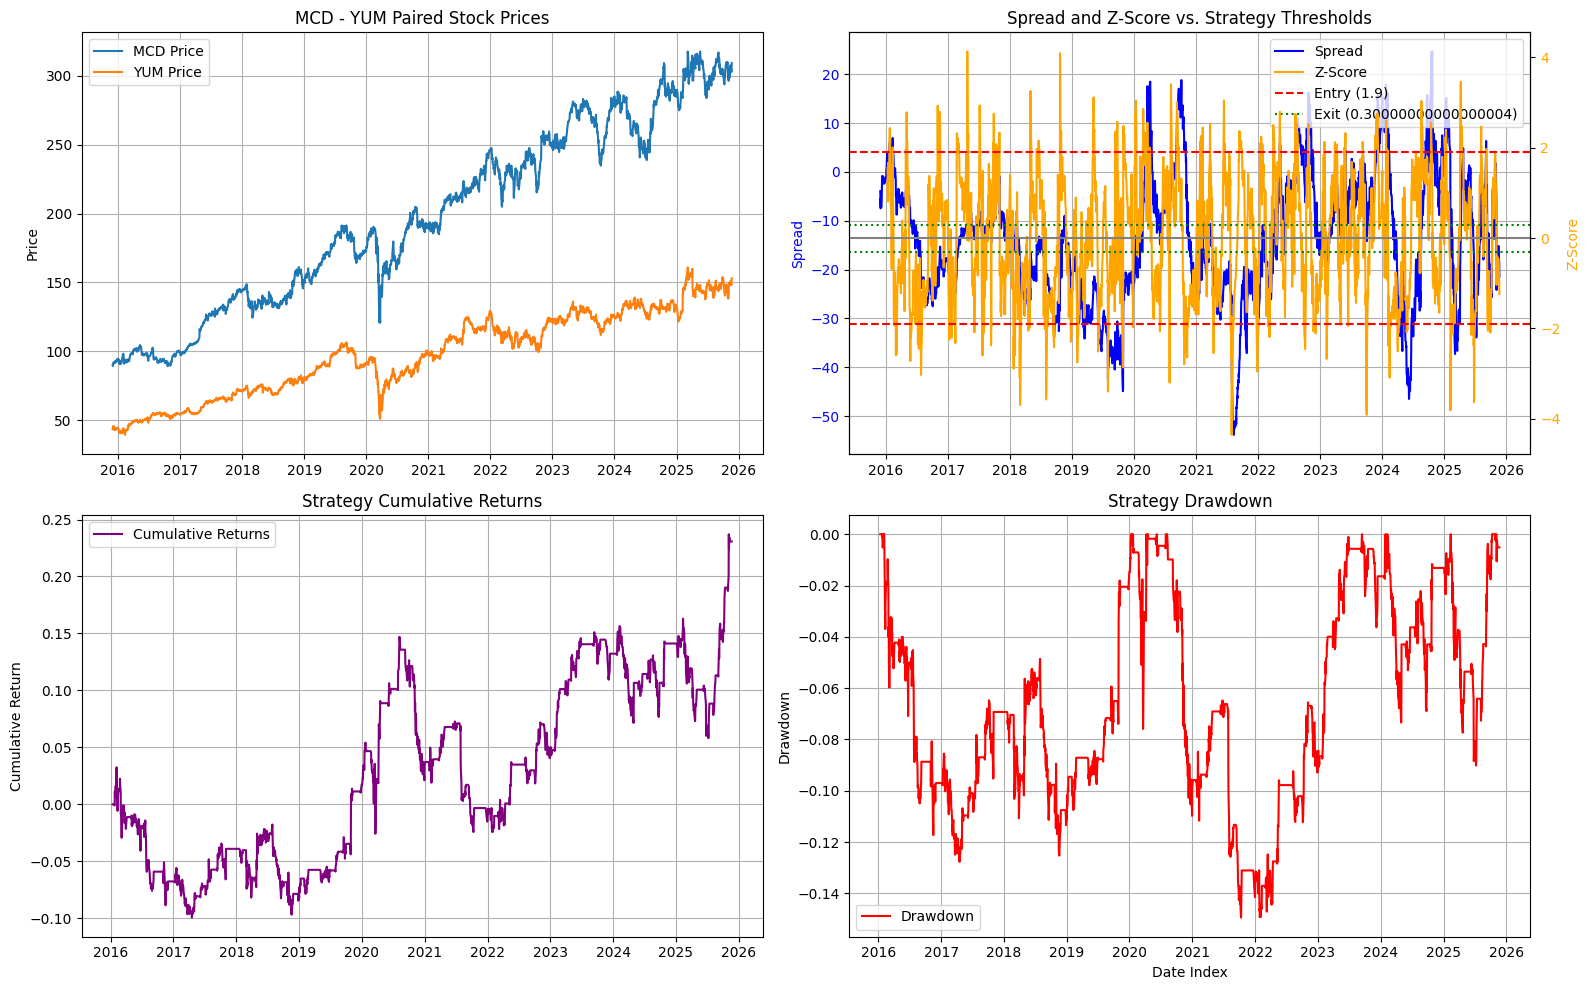

,total_return,sharpe_ratio,skewness,max_drawdown,returns
XOM-CVX,0.396695,0.479757,3.007694,-0.12921,Date 2016-01-12 -0.001000 2016-01-13 -0.00...
KO-PEP,0.030545,0.22582,7.760274,-0.027289,Date 2016-01-13 0.0 2016-01-14 0.0 2016-...
JPM-BAC,0.31126,0.533204,0.435992,-0.087599,Date 2016-01-13 0.0 2016-01-14 0.0 2016-...
BA-LMT,0.066576,0.404569,6.639689,-0.025154,Date 2016-01-13 0.0 2016-01-14 0.0 2016-...
MCD-YUM,0.230745,0.335604,1.066536,-0.149408,Date 2016-01-13 0.0 2016-01-14 0.0 2016-...


In [26]:
pairs = [
        ('XOM', 'CVX'),
        ('KO', 'PEP'),
        ('JPM', 'BAC'),
        ('BA', 'LMT'),
        ('MCD', 'YUM')
]

tickers = list(set([ticker for pair in pairs for ticker in pair]))
downloader = StockDataDownloader(tickers, '2015-11-28', '2025-11-24', '1d')
data = downloader.download()

backtest_results = {}
for s1, s2 in pairs:
    # 1. Instantiate the backtester
    bt = PairsTradingBacktest(data[s1], data[s2])
    
    # 2. Instantiate and run the optimizer
    optimizer = ThresholdOptimizer(bt)
    best_entry, best_exit, best_sharpe = optimizer.optimize()
    print(f"Pair {s1}-{s2}: Optimal entry: {best_entry}, exit: {best_exit}, Sharpe: {best_sharpe:.3f}")
    
    # 3. Create a final backtester with the optimal settings (OPTIONAL BUT RECOMMENDED)
    # Note: Creating a new instance ensures clean state and uses the calculated best parameters
    final_bt = PairsTradingBacktest(
        data[s1], 
        data[s2], 
        initial_capital=10000, 
        entry_z=best_entry, # Using the optimal values
        exit_z=best_exit, 
        trading_cost=0.001
    )
    result = final_bt.backtest()
    backtest_results[f'{s1}-{s2}'] = result
    
    # 4. Plot results for the optimal strategy
    final_bt.plot_all(result)

results_df = pd.DataFrame(backtest_results).T
results_df